In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from botorch.models import SingleTaskGP, ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.optim.optimize import optimize_acqf_list
from botorch.utils.transforms import unnormalize, normalize
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.utils.sampling import sample_simplex
from botorch.acquisition.objective import GenericMCObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.sampling.samplers import SobolQMCNormalSampler


In [3]:
noise_level = 0.2

bounds = torch.tensor([[-1.2], [1.2]])

def f(x, noise_level=noise_level):
    results = []
    for x_i in x:   
       sub_results = [
         (np.sin(6 *x_i[0])**3 * (1 - np.tanh(x_i[0] ** 2))) + (-1 + torch.rand(1)[0] * 2) * noise_level,
         .5 - (np.cos(5 * x_i[0] + 0.7)**3 * (1 - np.tanh(x_i[0] ** 2))) + (-1 + torch.rand(1)[0] * 2) * noise_level,
      ]
       results.append(sub_results)
    return torch.tensor(results, dtype=torch.float32)

def f_no_noise(x):
   return f(x, noise_level=0)

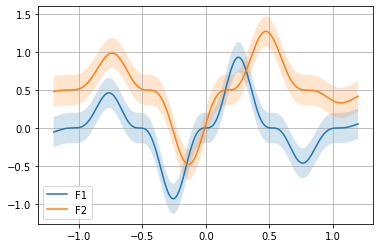

In [4]:
xs = np.linspace(bounds[0][0], bounds[1][0], 1000)
xs = xs.reshape((1000, -1))
ys_true = f(xs, noise_level=0).numpy()
plt.plot(xs, ys_true, label=["F1", "F2"])
# the fill method constructs a polygon of the specified color delimited by all the point
# in the xs and ys arrays.
plt.fill(np.concatenate([xs, xs[::-1]]),
         np.concatenate(([fx_i - 1 * noise_level for fx_i in ys_true],
                         [fx_i + 1 * noise_level for fx_i in ys_true[::-1]])),
         alpha=.2, ec="None")
plt.legend()
plt.grid()
plt.show()

In [5]:
for i in range(100):
    x_init = torch.tensor(bounds[0]) + torch.rand(3, 1) * (torch.tensor(bounds[1]) - torch.tensor(bounds[0]))
    ys_true = f(x_init, noise_level=0)
    ys_evaluated = f(x_init, noise_level=0.2)

    assert torch.abs(ys_true - ys_evaluated).max() < 0.2, torch.abs(ys_true - ys_evaluated).max()


ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [6]:
def generate_initial_data(n_samples):
    x_init = torch.tensor(bounds[0]) + torch.rand(n_samples, 1) * (torch.tensor(bounds[1]) - torch.tensor(bounds[0]))
    y_init = f(x_init)
    y_init_true = f(x_init, noise_level=0)
    return x_init, y_init, y_init_true

In [7]:
train_x, train_y, train_y_true = generate_initial_data(3)
print(train_x)
print(train_y)
print(train_y_true)

tensor([[ 0.2194],
        [-0.2268],
        [ 0.6715]])
tensor([[ 0.8954,  0.3495],
        [-0.9442, -0.1014],
        [-0.2986,  0.6543]])
tensor([[ 0.8630,  0.5108],
        [-0.8876, -0.2083],
        [-0.2692,  0.6304]])


ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [8]:
NUM_RESTARTS =  10
RAW_SAMPLES = 1024

standard_bounds = torch.tensor([[0.0], [1.0]])
MC_SAMPLES = 256

In [9]:
def initialize_model(train_x, train_y):
    
    train_x = normalize(train_x, bounds)
    models = []
    for i in range(train_y.shape[-1]):
        train_objective = train_y[:, i]
        models.append(
            SingleTaskGP(train_x, train_objective.unsqueeze(-1))
        )
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    return mll, model

In [10]:
def generate_next_candidate(x, y, n_candidates=1):
    
    mll, model = initialize_model(x, y)
    fit_gpytorch_model(mll)

    sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)

    train_x = normalize(x, bounds)
    with torch.no_grad():
        pred = model.posterior(normalize(train_x,bounds)).mean
    
    acq_fun_list = []
    for _ in range(n_candidates):
        
        weights = sample_simplex(2).squeeze()
        objective = GenericMCObjective(
            get_chebyshev_scalarization(
                weights,
                pred
            )
        )
        acq_fun = qNoisyExpectedImprovement(
            model=model,
            objective=objective,
            sampler=sampler,
            X_baseline=train_x,
            prune_baseline=True,
        )
        acq_fun_list.append(acq_fun)
    

    candidates, _ = optimize_acqf_list(
        acq_function_list=acq_fun_list,
        bounds=standard_bounds,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
        options={
            "batch_limit": 5,
            "maxiter": 200,
        }
    )

    return unnormalize(candidates, bounds)


In [11]:
def plot_candidates(candidates):
        xs = np.linspace(bounds[0][0], bounds[1][0], 1000)
        xs = xs.reshape((1000, -1))
        ys_true = f(xs, noise_level=0).numpy()
        plt.plot(xs, ys_true, label=["F1", "F2"])
        # the fill method constructs a polygon of the specified color delimited by all the point
        # in the xs and ys arrays.
        plt.fill(np.concatenate([xs, xs[::-1]]),
                np.concatenate(([fx_i - 1 * noise_level for fx_i in ys_true],
                                [fx_i + 1 * noise_level for fx_i in ys_true[::-1]])),
                alpha=.2, ec="None")

        plt.scatter(candidates[:, 0], candidates[:, 1], c='blue', label='Candidates')
        plt.scatter(candidates[:, 0], candidates[:, 2], c='orange', label='Candidates')

        plt.legend()
        plt.grid()
        plt.show()

ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


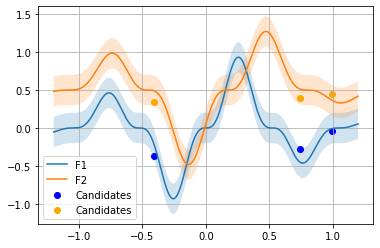

Iteration 0


lazy_tensor.py:1810: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


Candidates: tensor([[0.1127]])


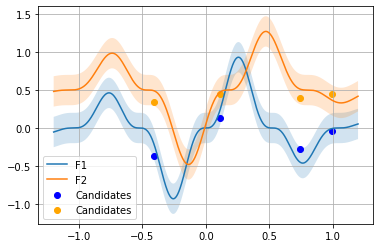

Iteration 1
Candidates: tensor([[-1.2000]])


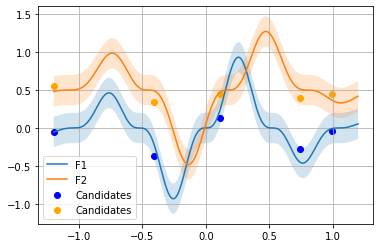

Iteration 2


cholesky.py:42: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  NumericalWarning,


Candidates: tensor([[-0.5988]])


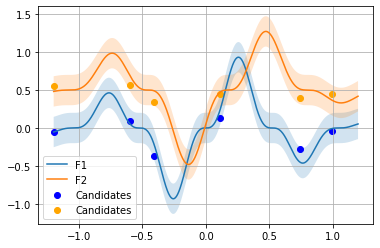

Iteration 3


cholesky.py:42: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  NumericalWarning,


Candidates: tensor([[1.2000]])


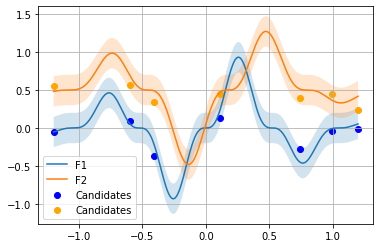

Iteration 4


cholesky.py:42: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  NumericalWarning,


Candidates: tensor([[0.4070]])


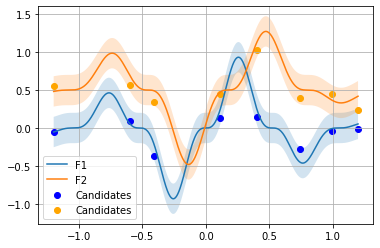

Iteration 5
Candidates: tensor([[-0.9371]])


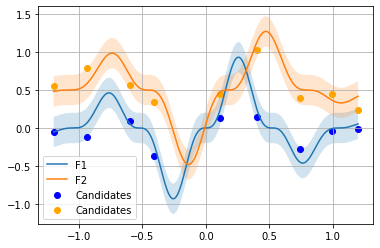

Iteration 6
Candidates: tensor([[-0.1939]])


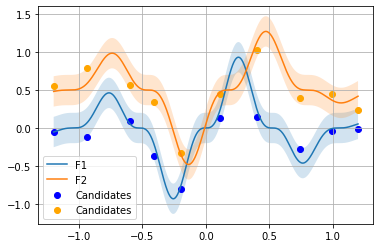

Iteration 7
Candidates: tensor([[-0.1230]])


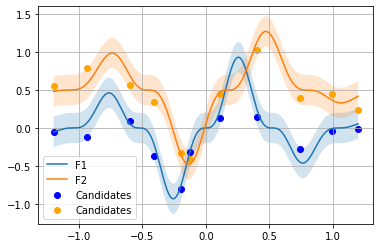

Iteration 8
Candidates: tensor([[-0.2474]])


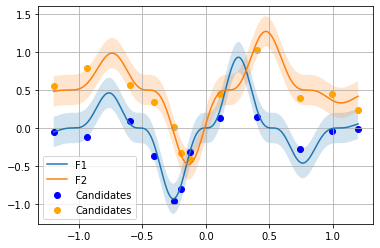

Iteration 9
Candidates: tensor([[-0.2663]])


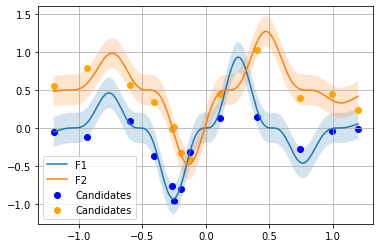

Iteration 10
Candidates: tensor([[-0.1476]])


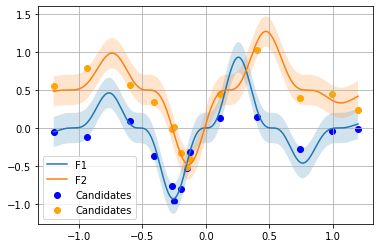

Iteration 11


cholesky.py:42: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  NumericalWarning,


Candidates: tensor([[-0.2282]])


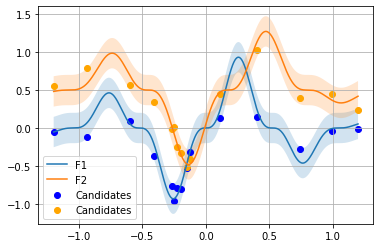

Iteration 12
Candidates: tensor([[-0.1666]])


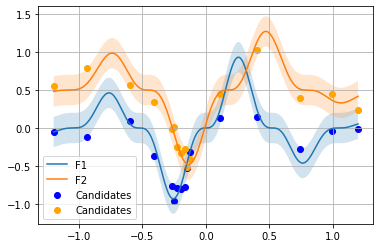

Iteration 13


cholesky.py:42: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  NumericalWarning,


Candidates: tensor([[-0.2093]])


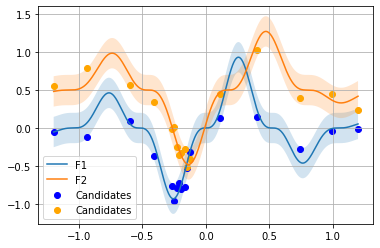

Iteration 14


cholesky.py:42: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  NumericalWarning,


Candidates: tensor([[-0.1813]])


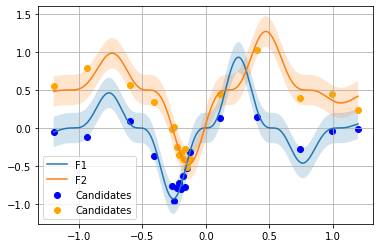

Iteration 15


cholesky.py:42: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  NumericalWarning,


Candidates: tensor([[-0.2828]])


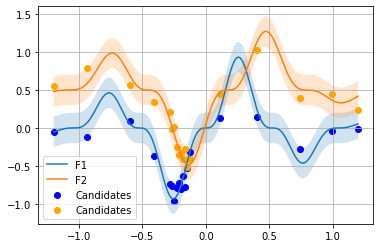

In [12]:
n_iter = 16
n_start = 3
n_samples = 1

x,y,y_true = generate_initial_data(n_start)

plot_candidates(torch.cat([x,y], dim=1))

for i in range(n_iter):
    print(f"Iteration {i}")

    candidates = generate_next_candidate(x, -y, n_candidates=n_samples)

    print(f"Candidates: {candidates}")

    x = torch.cat([x, candidates])
    y = torch.cat([y, f(candidates)], dim=0)

    plot_candidates(torch.cat([x,y], dim=1))

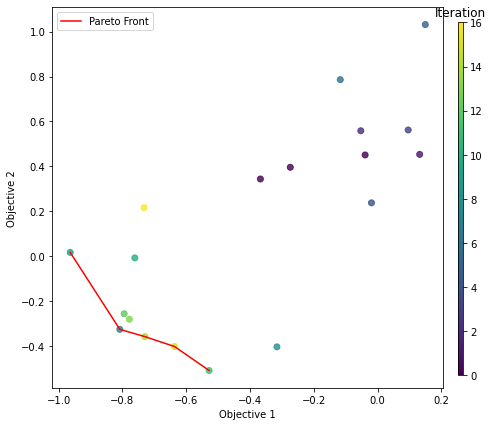

In [37]:
from matplotlib.cm import ScalarMappable
import numpy as np
from matplotlib import pyplot as plt
from botorch.utils.multi_objective.pareto import is_non_dominated


fig, axes = plt.subplots(1, 1, figsize=(7, 7))
algos = ["qNEHVI"]
cm = plt.cm.get_cmap('viridis')

batch_number = torch.cat(
    [torch.zeros(n_start), torch.arange(1, n_iter+1).repeat(n_samples, 1).t().reshape(-1)]
).numpy()

sc = axes.scatter(y[:, 0], y[:, 1], c=batch_number, alpha=0.8)

y_sorted = y[y[:, 0].sort()[1]]

axes.plot(
    [_y[0] for non_dominated, _y in zip(is_non_dominated(-y_sorted), y_sorted) if non_dominated],
    [_y[1] for non_dominated, _y in zip(is_non_dominated(-y_sorted), y_sorted) if non_dominated],
    label="Pareto Front",
    c="r"
)


axes.set_xlabel("Objective 1")
axes.set_ylabel("Objective 2")
norm = plt.Normalize(batch_number.min(), batch_number.max())
sm =  ScalarMappable(norm=norm, cmap=cm)

sm.set_array([])
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration")

axes.legend()
plt.show()
